# CSCK507 Mid Module - Toxic Comment Classification Challenge

## Table of Contents
[Section 1. Introduction](#introduction)
- [Import Dependencies](#import-dependencies)
- [Loading Kaggle dataset into DataFrame](#import-dependencies)
- [Initialise SpaCy Model ](#import-dependencies)

[Section 2. Data Exploration & Analysis](#data-exploration-&-analysis)
- [2.1 Data Preparation and Preprocessing](#data-exploration-&-analysis)
    - [2.1.1 Dataset Alignment](#data-preprocessing)
    - [2.1.2 Text Preprocessing](#data-preprocessing)
    - [2.1.3 Tokenisation and Lemmatisation](#data-preprocessing)
    - [2.1.4 Combining Tokenised Features and Labels for Training and Test Dataset](#data-preprocessing)
- [2.2 Data Analysis Requirements](#data-exploration-&-analysis)
    - [2.2.1 Number of Sentences & Tokens Per Class](#data-preprocessing)
    - [2.2.2 Data Imbalance](#data-imbalance)
    - [2.2.3 Understanding the Most Common Words](#data-preprocessing)
    - [2.2.4 Data Analysis Summary](#data-imbalance)
    
[Section 3. Machine Learning Model Development](#data-exploration-&-analysis)
- [3.1 Feature Extraction Methods](#data-preprocessing)
    - [3.1.1 TF-IDF Implementation](#data-preprocessing)
    - [3.1.2 Word Embedding through Word2Vec](#data-preprocessing)
- [3.2 Model Selection & Training](#data-exploration-&-analysis)
    - [3.2.1 Logistic Regression](#data-preprocessing)
    - [3.2.2 Multinomial Naive Bayes](#data-preprocessing)
    - [3.2.3 Multi-Layer Perceptron](#data-preprocessing)


[Section 4. Evaluation of Selected Models](#data-exploration-&-analysis)
- [4.1 Feature Extraction Methods](#data-preprocessing)



---
## Section 1. Introduction

Originating in 2018, this challenge revolves around classifying different levels of toxicity in online comments. The dataset from the inaugural competition is utilized to analyze and evaluate the performance of various machine learning algorithms in categorizing six types of toxicity. The primary goal is not only to find an optimal solution but to understand the process of evaluating machine learning algorithms' performance in a classification task. This individual assessment involves data analysis, algorithm selection, and the exploration of feature extraction methods to uncover insights into the nuances of toxic comment classification.

The Toxic Comment Classification Challenge and dataset can be obtained here: [Kaggle Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data)

### Importing Dependencies

In [1]:
# General
import os
import pandas as pd 
import numpy as np

# Data Preprocessing
import re  
import nltk
from nltk.corpus import stopwords

# Feature Extraction  
import dill
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.base import TransformerMixin

# Machine Learning
# import eli5
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report, f1_score,
                             multilabel_confusion_matrix, precision_score,
                             recall_score, roc_auc_score)

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Warning Handling
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### Load Kaggle dataset into DataFrame

In [2]:
df = pd.read_csv('dataset/train.csv')
df_test_labels = pd.read_csv('dataset/test_labels.csv')
df_test_comment = pd.read_csv('dataset/test.csv')

### Initialise SpaCy Model 

In [3]:
try:
    spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm')
except (LookupError, OSError):
    print('Run: python -m spacy download en_core_web_sm')

try:
    nltk_stop = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk_stop = stopwords.words('english')

---
## Section 2. Data Exploration & Analysis

In [4]:
df.sample(10).head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
61223,a3e20f365755036e,"Interview with Kevin Dubrow \n\nElizabeth ,\n\...",0,0,0,0,0,0
99770,15de9a2ba11039aa,"""\n\nMaybe we can mention the city known Perso...",0,0,0,0,0,0
34693,5ca860522177f869,NPA Warning \n\nPlease see Wikipedia's no pers...,0,0,0,0,0,0
100396,1977492ef64d0677,Parts read as if translated from another langu...,0,0,0,0,0,0
125306,9e3b46c65a94ba78,"""\nThis website is really joke. One of your ed...",1,0,0,0,0,0
154326,ac5d5e4efcc4f0c0,Ok. I'm gonna work on it. Thank for your advic...,0,0,0,0,0,0
17369,2dd80d691dd88dca,"Just the same, the controversies need to be in...",0,0,0,0,0,0
10744,1c6814105fb11385,"""\n\nDanilovic\nAlright, we'll stay away from ...",0,0,0,0,0,0
1690,04965be9ea5a4214,"I would say this is bad form, but the whole di...",0,0,0,0,0,0
128945,b19b93e000a40e63,Thank you \nthank you for everything you've do...,0,0,0,0,0,0


In [5]:
df.info()
print("The table dimensions are:",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
The table dimensions are: (159571, 8)


In [6]:
print(df.loc[30566])

id                                                5125ff19698165c6
comment_text     "\n\n""I think we should kill all the jews and...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          0
threat                                                           1
insult                                                           1
identity_hate                                                    1
Name: 30566, dtype: object


As shown above, this task necessitates a multi-label classification approach for a more accurate understanding and identification of hate comments as they typically exhibit a nuanced interplay of multiple labels. 

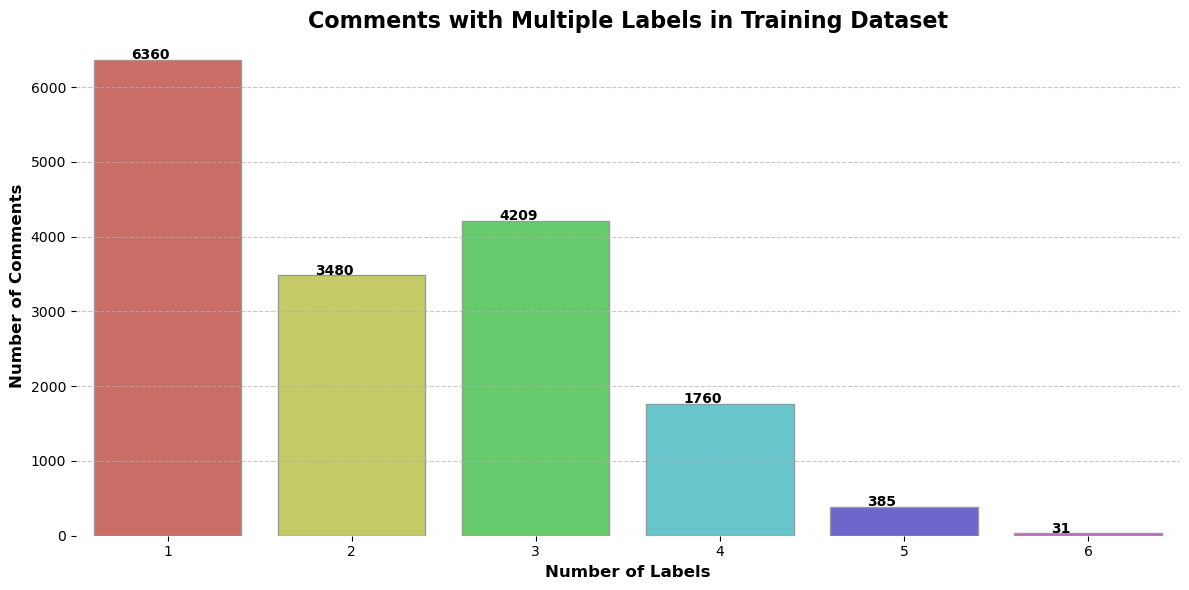

In [7]:
def plot_multilabel_count(df, title, offset=10):
    row_sums = df.iloc[:, 2:].sum(axis=1)
    label_counts = row_sums.value_counts().sort_index(ascending=True)[1:]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="hls", edgecolor=".6")
    
    for i, v in enumerate(label_counts.values):
        plt.text(i - 0.2, v + offset, str(v), color='black', fontweight='bold')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Number of Labels', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Comments', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# Plot number of comments with multiple labels
plot_multilabel_count(df, 'Comments with Multiple Labels in Training Dataset')

### Dataset Alignment

In [8]:
try:
    class_labels = list(df.columns[2:])
    print("Class labels extracted.")

    # Remove rows with -1 from 'df_test' since they are not used for scoring
    print(f'df_test before removing -1: {df_test_labels.shape}')
    
    for class_label in class_labels:
        df_test_labels = df_test_labels[df_test_labels[class_label] != -1]
    print(f'df_test after removing -1: {df_test_labels.shape}')

    # Left join 'df_test' and 'df_test_comment' on the 'id' column
    df_test = pd.merge(df_test_labels, df_test_comment, on='id', how='left')

    # Create a new DataFrame called 'df_test' and match the column structure of 'df'
    df_test = df_test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
    print("New DataFrame 'df_test' created.")

except KeyError as ke:
    print(f"Error: {ke} not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Class labels extracted.
df_test before removing -1: (153164, 7)
df_test after removing -1: (63978, 7)
New DataFrame 'df_test' created.


### Data Preprocessing, Tokenisation, and Lemmatisation

The preprocessing step plays a critical role in cleansing and standardising textual data for manageability purposes. This stage typically consists of tasks, such as:

- Removing URLs, extra spaces, and non-English characters
- Trimming start and end white spaces
- Eliminating leading and trailing spaces and quotation marks
- Discarding single characters
- Eliminating punctuation without converting to lowercase

**Note:** An area worth noting for hate speech detection is that preserving the original case is essential, as individuals expressing anger may resort to typing in all caps, and ignoring case distinctions would hinder the effectiveness of the model. As such, it is not performed below in the preprocessing stage.

In [9]:
def preprocess_text(text, nltk_stop=None):
    try:
        if nltk_stop is None:
            nltk_stop = set(stopwords.words('english'))
    except LookupError:
        print("NLTK stopwords not available. Consider downloading with nltk.download('stopwords').")

    try:
        # Combine URL removal, extra space replacement, and Non-English characters removal
        text = re.sub(r"(http\S+|www\S+|https\S+)|[^\x00-\x7F]+", " ", text)
        # Remove start and end white spaces
        text = text.strip()
        # Remove leading and trailing spaces and quotation marks
        text = text.strip('"')
        # Remove single characters
        text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
        # Remove punctuations.
        text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
        # Stopword Removal using set operations
        text = ' '.join(set(text.split()) - nltk_stop)

        return text

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

### Tokenisation and Lemmatisation

In [10]:
def tokenize_lemma_text(documents):
    """
    Tokenize a list of documents and perform the following:
    1. Break text into individual words or subword tokens.
    2. Reduce words to their base or root form using lemmatization.
    3. Remove stop words and non-alphabetic characters.

    Utilises spaCy's nlp.pipe for efficient batch processing.

    :param documents: List of strings representing documents.
    :return: List of lists of strings, where each list corresponds to the lemmatized tokens of a document.
    """
    lemmatized_tokens_list = []
    
    # Process documents using spaCy's nlp.pipe with 'NER' and 'Parser' components disabled utilising 4 core parallel processing:
    for doc in nlp.pipe(documents, disable=["ner", "parser"], batch_size=5000, n_process=4):
        lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        lemmatized_tokens_list.append(lemmatized_tokens)

    return lemmatized_tokens_list

In many tokenisation tasks, especially those emphasizing lemmatisation and stop word removal, the additional linguistic information provided by the 'NER' and 'Parser' components is often unnecessary. 

**Disabling** these components during the processing of documents using 'nlp.pipe' can substantially reduce computational load and significantly improve efficiency and speed. This is particularly crucial when dealing with extensive amounts of text data, presenting a trade-off between computational resources and the need for specific linguistic information tailored to the task.

**Note:** A critical facet worth discussing is that while SpaCy conveniently handles all aspects performed in the 'preprocess_text' function regarding URL removal, whitespace trimming, stopword removal, etc. The linguistic analysis performed by SpaCy introduces overhead, making it relatively slower for simple tasks compared to a more lightweight solution like RegEx.

In [11]:
# Preprocess the train dataset
df['comment_text'] = df['comment_text'].apply(preprocess_text)
print("Preprocessed training dataset:")

Preprocessed training dataset:


In [12]:
#Display random rows from the training set
random_rows_train = df.sample(n=10) 
display(random_rows_train)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
72543,c220155a2d591adb,preferable Yes forums source sure would ubisoft,0,0,0,0,0,0
150330,6a745c806bde3040,Hey texts saw Scientology anon servers edited ...,0,0,0,0,0,0
44340,7668ee206721682b,Eyeghe spells Ey gh article The ghe Eyegh,0,0,0,0,0,0
106143,37d7e12479178ca3,tennis edits saw Writer ur hey deserve Barnsta...,0,0,0,0,0,0
66605,b23d71a15e856f66,linking articles Closedmouth Lightmouse offeri...,0,0,0,0,0,0
119967,8186fb6272723b56,whether transported explicitly ie speaking Eng...,0,0,0,0,0,0
86631,e7b44175a6e0b55f,please encyclopedia well information deletion ...,0,0,0,0,0,0
34478,5c111a08aa3fba78,block still FUCK eat 70 range How mom 245 YOU ...,1,1,1,0,0,0
131065,bd45dcaf69f97f3a,We appraisal It use line early The study Hi re...,0,0,0,0,0,0
150047,65f9ec8f2818bb34,cunt fat fucking ugly Your spotty,1,1,1,0,1,1


In [13]:
# Preprocess the test dataset
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)

In [14]:
# Tokenizing the train and test datasets
tokenized_comment_train = tokenize_lemma_text(df['comment_text'].tolist())
tokenized_comment_test = tokenize_lemma_text(df_test['comment_text'].tolist())

In [15]:
# Get labels for train and test data
y_train = df[class_labels]
y_test = df_test[class_labels]

### Combining Tokenised Text Features & Labels for Training and Test Dataset

In [16]:
# Training data
df_train = pd.DataFrame({
    'comment_text': tokenized_comment_train,          # Tokenised comment text
    'toxic': y_train['toxic'],                        # Toxicity label
    'severe_toxic': y_train['severe_toxic'],          # Severe toxicity label
    'obscene': y_train['obscene'],                    # Obscenity label
    'threat': y_train['threat'],                      # Threatening language label
    'insult': y_train['insult'],                      # Insult label
    'identity_hate': y_train['identity_hate']         # Identity hate label
})

display(df_train.head())
print("The train dataset dimensions are:",df.shape)

# Test data
df_test = pd.DataFrame({
    'comment_text': tokenized_comment_test,     # Tokenised comment text for testing
    'toxic': y_test['toxic'],                   # Toxicity label for testing
    'severe_toxic': y_test['severe_toxic'],     # Severe toxicity label for testing
    'obscene': y_test['obscene'],               # Obscenity label for testing
    'threat': y_test['threat'],                 # Threatening language label for testing
    'insult': y_test['insult'],                 # Insult label for testing
    'identity_hate': y_test['identity_hate']    # Identity hate label for testing
})

display(df_test.head())
print("The test dataset dimensions are:",df_test.shape)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[Dolls, Metallica, closure, vandalism, Hardcor...",0,0,0,0,0,0
1,"[talk, I, utc, seemingly, thank, colour, d, ma...",0,0,0,0,0,0
2,"[hey, try, guy, war, info, remove, constantly,...",0,0,0,0,0,0
3,"[form, Transport, good, More, nomination, ie, ...",0,0,0,0,0,0
4,"[chance, sir, hero, remember, page]",0,0,0,0,0,0


The train dataset dimensions are: (159571, 8)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[understand, discussion, thank, highly, think,...",0,0,0,0,0,0
1,"[horrible, dear, site, god]",0,0,0,0,0,0
2,"[existent, add, non, somebody, personally, Rel...",0,0,0,0,0,0
3,"[try, University, need, Albany, Institutions, ...",0,0,0,0,0,0
4,"[reader, relevance, deletion, wikipedia, relev...",0,0,0,0,0,0


The test dataset dimensions are: (63978, 7)


### 2.1 Requirements of Task 1

**Number of Sentences and Tokens**
- Analyze the number of sentences and tokens per class
- Check if the dataset is unbalanced or not

**Most Common Words Analysis**
- Examine the most common words for each class.

### Counting Number of Sentences & Tokens Per Class

In [17]:
import pandas as pd

class_counts = {'class_label': [], 'num_sentences': [], 'num_tokens': []}

for class_label in class_labels:
    class_comments = df_train[df_train[class_label] == 1]['comment_text'].tolist()

    total_sentences = 0
    total_tokens = 0

    for comment in class_comments:
        # Join the list of comments into a single string
        comment_text = " ".join(comment)

        # Count the number of sentences in the comment
        sentences = comment_text.split('.')
        total_sentences += len(sentences)

        # Count the number of tokens in the comment
        tokens = comment_text.split()
        total_tokens += len(tokens)

    class_counts['class_label'].append(class_label)
    class_counts['num_sentences'].append(total_sentences)
    class_counts['num_tokens'].append(total_tokens)
    
class_counts_df = pd.DataFrame(class_counts)

print(class_counts_df)

     class_label  num_sentences  num_tokens
0          toxic          15294      244367
1   severe_toxic           1595       19334
2        obscene           8449      126529
3         threat            478        6871
4         insult           7877      115113
5  identity_hate           1405       21905


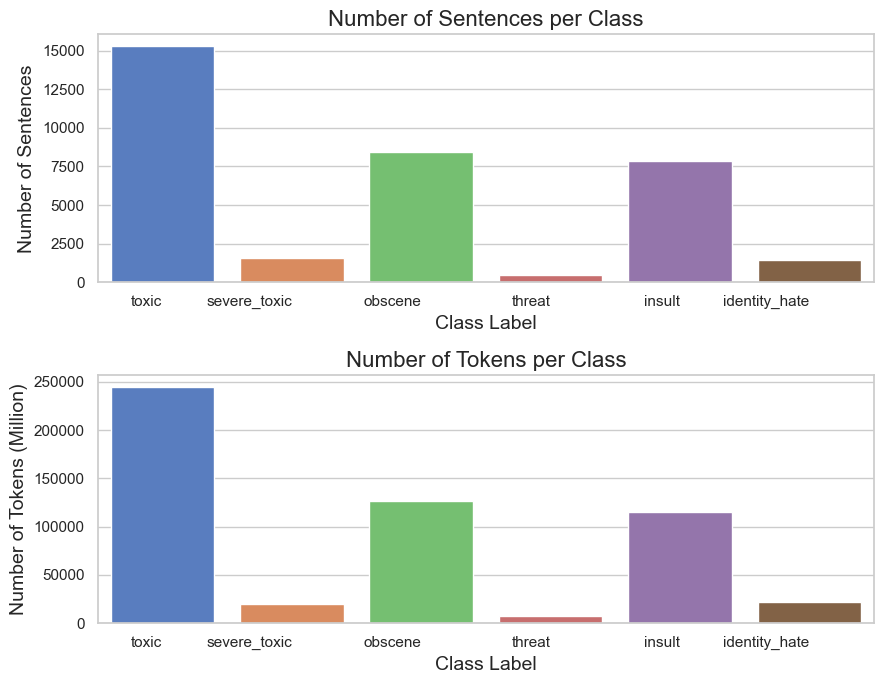

In [18]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(9, 7))

# Plot the number of sentences per class
sentences_plot = sns.barplot(
    ax=axes[0],
    x='class_label',
    y='num_sentences',
    data=class_counts_df,
    palette="muted"
)
sentences_plot.set_title('Number of Sentences per Class', fontsize=16)
sentences_plot.set_xlabel('Class Label', fontsize=14)
sentences_plot.set_ylabel('Number of Sentences', fontsize=14)
sentences_plot.set_xticklabels(sentences_plot.get_xticklabels(), ha='right') 

# Plot the number of tokens per class
tokens_plot = sns.barplot(
    ax=axes[1],
    x='class_label',
    y='num_tokens',
    data=class_counts_df,
    palette="muted"
)
tokens_plot.set_title('Number of Tokens per Class', fontsize=16)
tokens_plot.set_xlabel('Class Label', fontsize=14)
tokens_plot.set_ylabel('Number of Tokens', fontsize=14)
tokens_plot.set_xticklabels(tokens_plot.get_xticklabels(), ha='right')  

plt.tight_layout() 
plt.show()

warnings.filterwarnings(action='ignore')

### Understanding the Most Common Words in Training Data

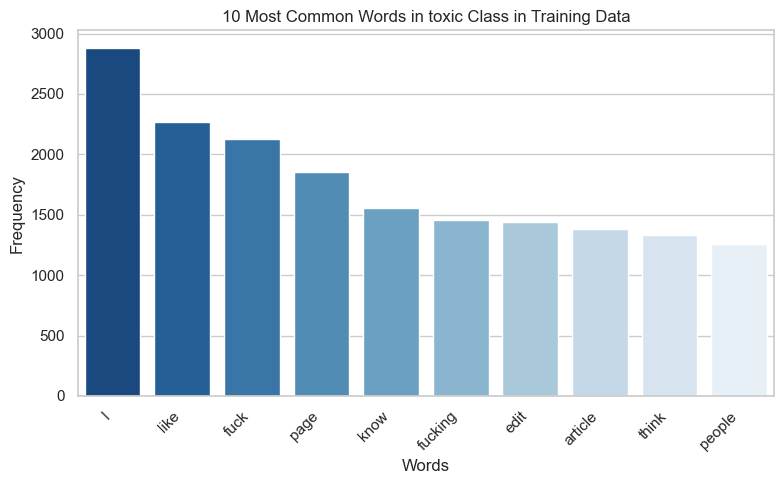

Most common words in toxic class: [('I', 2882), ('like', 2268), ('fuck', 2129), ('page', 1854), ('know', 1556), ('fucking', 1459), ('edit', 1441), ('article', 1381), ('think', 1333), ('people', 1259)]


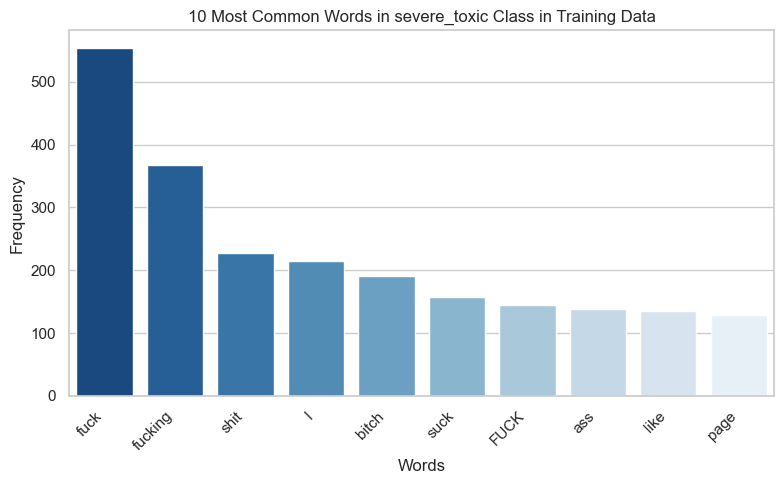

Most common words in severe_toxic class: [('fuck', 554), ('fucking', 367), ('shit', 228), ('I', 214), ('bitch', 191), ('suck', 157), ('FUCK', 144), ('ass', 138), ('like', 136), ('page', 129)]


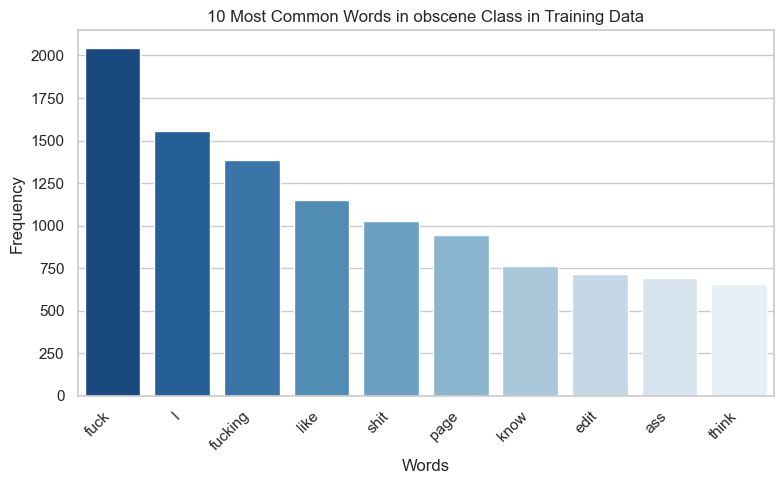

Most common words in obscene class: [('fuck', 2045), ('I', 1557), ('fucking', 1387), ('like', 1153), ('shit', 1030), ('page', 944), ('know', 765), ('edit', 718), ('ass', 695), ('think', 658)]


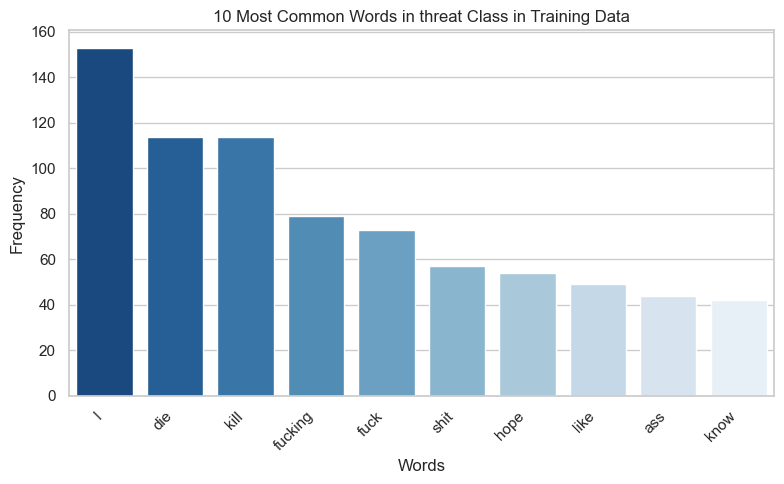

Most common words in threat class: [('I', 153), ('die', 114), ('kill', 114), ('fucking', 79), ('fuck', 73), ('shit', 57), ('hope', 54), ('like', 49), ('ass', 44), ('know', 42)]


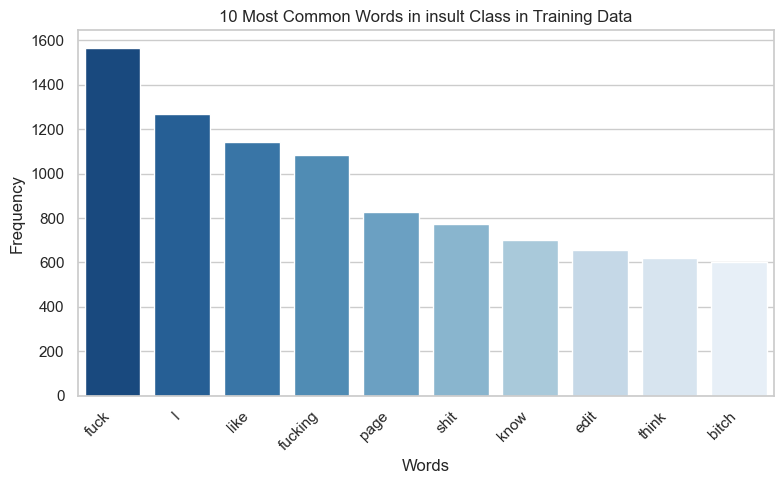

Most common words in insult class: [('fuck', 1565), ('I', 1267), ('like', 1141), ('fucking', 1084), ('page', 827), ('shit', 774), ('know', 701), ('edit', 658), ('think', 621), ('bitch', 601)]


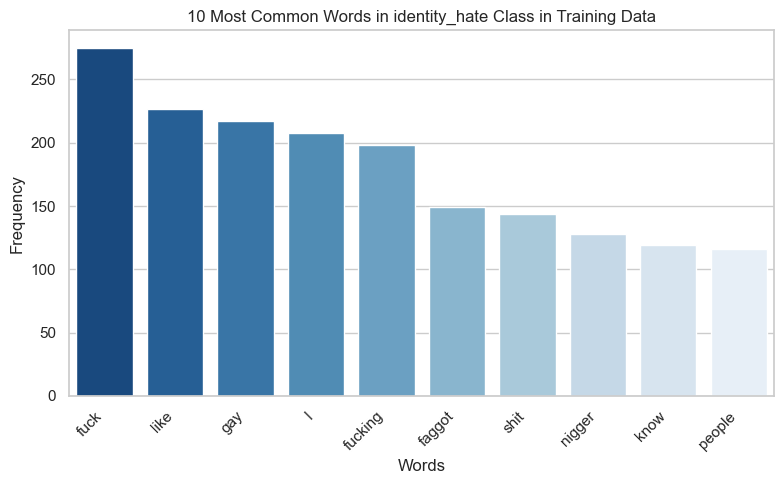

Most common words in identity_hate class: [('fuck', 275), ('like', 227), ('gay', 217), ('I', 208), ('fucking', 198), ('faggot', 149), ('shit', 144), ('nigger', 128), ('know', 119), ('people', 116)]


In [19]:
def plot_common_words(counts, title):
    labels = [word for word, _ in counts]
    freqs = [count for _, count in counts]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=labels, y=freqs, palette="Blues_r")  
    
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()  
    plt.show()

for label in class_labels:
    words = []
    for comment in df_train[df_train[label] == 1]['comment_text']:
        words.extend(comment)
    
    most_common_words = Counter(words).most_common(10)
    
    # Plot and display the 10 most common words
    plot_common_words(most_common_words, f'10 Most Common Words in {label} Class in Training Data')
    
    print(f'Most common words in {label} class: {most_common_words}')

warnings.filterwarnings(action='ignore')

### Exploring Class Distribution and Imbalance 

In [21]:
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

total_samples = len(df)

for column in class_columns:
    # Count the occurrences of each class label
    class_counts = df[column].value_counts()
    
    # Print the counts and percentages for each class label
    print(f"{column.capitalize()} Counts:")
    for index, count in class_counts.items():
        # Determine the class label (Non-<class_label> for index 0, <class_label> otherwise)
        class_label = "Non-" + column if index == 0 else column
        # Calculate the percentage of samples for the current class label
        percentage = (count / total_samples) * 100
        # Print count and percentage for each class label
        print(f"{class_label}: {count} ({percentage:.2f}%)")
    
    # Print a separator line between class labels
    print(f"\n{'='*30}\n")
    

Toxic Counts:
Non-toxic: 144277 (90.42%)
toxic: 15294 (9.58%)


Severe_toxic Counts:
Non-severe_toxic: 157976 (99.00%)
severe_toxic: 1595 (1.00%)


Obscene Counts:
Non-obscene: 151122 (94.71%)
obscene: 8449 (5.29%)


Threat Counts:
Non-threat: 159093 (99.70%)
threat: 478 (0.30%)


Insult Counts:
Non-insult: 151694 (95.06%)
insult: 7877 (4.94%)


Identity_hate Counts:
Non-identity_hate: 158166 (99.12%)
identity_hate: 1405 (0.88%)




Looking at the results, it's clear that there's a big difference in the number of non-hateful and hateful instances in the datasets.

To tackle this imbalance during training, we decided to use class weights instead of changing the data. Class weights are figured out by taking the inverse of how often each class appears in the training data. Here's the formula we used:

class weight = 1/class frequency

Because of the noticeable imbalance in our data, it's suggested to rethink using accuracy as the main way to measure how well the model is doing. It's better to consider alternatives like precision, recall, or the area under the receiver operating characteristic curve (AUC).

Following the competition's guidelines, we've chosen to use ROC-AUC as the main way to evaluate our models. This metric gives a thorough look at how well the model performs across different classification thresholds. It helps us better understand how good the model is at distinguishing between classes, especially when the data is imbalanced.

---
## Section 3. Feature Extraction

### TF-IDF Implementation

TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF:** Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

**TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).**

**IDF:** Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

**Formula:** IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [22]:
# Save the TF-IDF vectorizer
def save_tfidf_vectorizer(vectorizer, filename):
    with open(filename, 'wb') as f:
        dill.dump(vectorizer, f)
        

# Load the TF-IDF vectorizer if it exists, otherwise return None
def load_tfidf_vectorizer(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return dill.load(f)
    else:
        return None
    

# Create function to compute TF-IDF features
def compute_tfidf_features(vectorizer, train_data, test_data):
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)
    return X_train_tfidf, X_test_tfidf

tfidf_vectorizer_filename = 'model/tfidf_vectorizer.dill'
tfidf_vectorizer = load_tfidf_vectorizer(tfidf_vectorizer_filename)

if tfidf_vectorizer is None:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=75_000, tokenizer=lambda x: x, preprocessor=lambda x: x)
    save_tfidf_vectorizer(tfidf_vectorizer, tfidf_vectorizer_filename)

# Call the 'compute_tfidf_features' function for the training and test features
X_train_tfidf, X_test_tfidf = compute_tfidf_features(tfidf_vectorizer, df_train['comment_text'], df_test['comment_text'])

# Extract class labels
y_train_tfidf = df_train[class_labels]
y_test_tfidf = df_test[class_labels]

In [23]:
print("TF-IDF Information:")
print(f"Training TF-IDF Features Shape: {X_train_tfidf.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Testing TF-IDF Features Shape: {X_test_tfidf.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

TF-IDF Information:
Training TF-IDF Features Shape: (159571, 75000)
Training Labels Shape: (159571, 6)
Testing TF-IDF Features Shape: (63978, 75000)
Testing Labels Shape: (63978, 6)


### Word Embedding

Word2Vec excels in capturing semantic relationships, providing context-aware representations, and offering transferable features. It aims to learn distributed representations (embeddings) of words in a continuous vector space, capturing semantic relationships and contextual information.

In [25]:
def load_word2vec_model(filename):
    if os.path.exists(filename):
        return Word2Vec.load(filename)
    else:
        return None

# Function to save Word2Vec model
def save_word2vec_model(model, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    model.save(filename)

# Custom transformer class for Word2Vec
class Word2VecVectorizer(TransformerMixin):
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def fit(self, X, y=None):
        # No fitting needed for Word2Vec
        return self

    def transform(self, X):
        return [self.get_document_vector(doc) for doc in X]

    def get_document_vector(self, document):
        document_vector = np.zeros(self.word2vec_model.vector_size)
        n_words = 0
        for word in document:
            if word in self.word2vec_model.wv:
                document_vector += self.word2vec_model.wv[word]
                n_words += 1
        if n_words > 0:
            document_vector /= n_words
        return document_vector

# Instantiate or load the Word2Vec model
word2vec_model_filename = './word2vec_model'
word2vec_model = load_word2vec_model(word2vec_model_filename)

if word2vec_model is None:
    # Similarly, the tokenized text is used as input for the Word2Vec model
    word2vec_model = Word2Vec(sentences=df_train['comment_text'], vector_size=100, window=5, min_count=1, workers=4)
    save_word2vec_model(word2vec_model, word2vec_model_filename)

# Calling the 'transform' method of Word2VecVectorizer for the training and test features
word2vec_vectorizer = Word2VecVectorizer(word2vec_model)
X_train_word2vec = word2vec_vectorizer.transform(df_train['comment_text'])
X_test_word2vec = word2vec_vectorizer.transform(df_test['comment_text'])

# Extract class labels
y_train_word2vec = df_train[class_labels]
y_test_word2vec = df_test[class_labels]

In [26]:
print("Word2Vec Information:")
print(f"Training Word2Vec Features Length: {len(X_train_word2vec)}")
print(f"Training Labels (Word2Vec) Shape: {y_train_word2vec.shape}")
print(f"Testing Word2Vec Features Length: {len(X_test_word2vec)}")
print(f"Testing Labels (Word2Vec) Shape: {y_test_word2vec.shape}")

Word2Vec Information:
Training Word2Vec Features Length: 159571
Training Labels (Word2Vec) Shape: (159571, 6)
Testing Word2Vec Features Length: 63978
Testing Labels (Word2Vec) Shape: (63978, 6)


### Saving TF-IDF and Word2Vec Models
Saving the TF-IDF and Word2Vec models are common practice in ML workflow, allowing for:

Reusability: Saved models can be easily reused in other projects or shared with collaborators, saving time and resources.

Scalability: For large datasets, training models can be computationally expensive. Saving and loading pre-trained models allows for scalability without retraining.

Consistency: Saving models ensures that the same representation is used consistently throughout the development and deployment phases. 

### TF-IDF vs Word2Vec

Both TF-IDF and Word2Vec are powerful tools used in language processing. TF-IDF is straightforward, giving importance to words based on how often they appear in a document compared to a larger collection of documents. It works well when there's not a lot of data but doesn't grasp the meaning of words and represents documents in a fixed way.

On the flip side, Word2Vec is better at understanding the meaning of words and their relationships. It considers the context in which words appear and can measure how similar words are. However, it needs a good amount of data to work effectively.

In the context of hate speech, TF-IDF might flag problematic documents based on rare negative words, while Word2Vec could better capture the semantic nuances, recognising negative sentiments and similarities between phrases with similar meanings. Nevertheless, both methods alone may not comprehensively detect hate speech, and more advanced techniques, such as deep learning models with contextual embeddings, may be necessary for robust detection, which will be explored in Section 4.


## Section 4. Machine Learning Model Development and Evaluation

In this secion we cover 3 ML Models. Additionally, given that the task involves solving a multi-label classification problem, we'll employ classifiers encapsulated within a OneVsRestClassifier wrapper. The three models and reasoning are:

**Logistic Regression:**

Advantages:
Interpretability: Logistic Regression is a simple and interpretable model, making it easy to understand the impact of individual features on the prediction.
Efficiency: It performs well with a large number of features, making it suitable for NLP tasks where text data is often high-dimensional.

Applicability to NLP: Logistic Regression is a natural fit for binary classification tasks, such as hate speech detection, where the goal is to classify text into categories like hate speech or non-hate speech. It works well with TF-IDF features or word embeddings.

**Support Vector Machine:**

**Multinomial Naive Bayes:**

Advantages:
Efficiency: Naive Bayes is computationally efficient and fast, making it suitable for large datasets.
Works well with text data: It assumes that features are conditionally independent given the class, which simplifies calculations and often works well with text data.

Applicability to NLP: Multinomial Naive Bayes is commonly used in text classification tasks, including hate speech detection. It's particularly effective when dealing with word frequency representations like TF-IDF.

**MLPClassifier (Neural Network):**

Advantages:
Non-linearity: Neural networks, including MLP (Multi-Layer Perceptron), can capture complex non-linear relationships in data, allowing for better representation learning.

Flexibility: Neural networks can be adapted to various architectures, making them suitable for diverse NLP tasks.

Applicability to NLP: MLPClassifier, being a type of neural network, can capture intricate patterns and relationships in text data. It's particularly useful when dealing with deep learning approaches for NLP tasks, offering high flexibility and adaptability.


In [27]:
def evaluate_and_visualize_classifier(clf, X_test, y_test, class_labels, name):
    y_pred = clf.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc_roc = roc_auc_score(np.array(y_test), y_pred, average='macro')

    # Output performance report
    out_dict = {'model': name, 'accuracy': accuracy, 'precision': precision,
                'recall': recall, 'f1': f1, 'auc_roc': auc_roc}

    # Output confusion matrix
    conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=class_labels, zero_division=1)

    # Visualize multilabel confusion matrix
    plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name=name)

    return out_dict, class_report, conf_matrix

def plot_multilabel_confusion_matrix(conf_matrix, class_labels, model_name):
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    for cm, label, ax in zip(conf_matrix, class_labels, axs.flatten()):
        sns.heatmap(cm, annot=True, fmt='d', cmap=None, ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(label)

    plt.tight_layout()
    plt.suptitle(f'Multilabel Confusion Matrix ({model_name})', y=1.02)
    plt.show()

### TF-IDF Classifiers

In [ ]:
# Initialise classifiers
logistic_regression = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0)
svm = LinearSVC(class_weight='balanced', max_iter=1000, random_state=0)
multinomial_nb = MultinomialNB()
mlp_classifier = MLPClassifier(max_iter=1000, random_state=0, hidden_layer_sizes=(100))

classifiers = {
    'LogisticRegression': logistic_regression,
    'SVM': svm,
    'MultinomialNB': multinomial_nb,
    'MLPClassifier': mlp_classifier
}

# Initialie StratifiedKFold
num_splits = 5
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=0)

metrics = []
class_reports = {}
conf_matrices = {}

for key, classifier in classifiers.items():
    classifiers[key] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X_train_tfidf, y_train_tfidf)
    out_dict, class_report, conf_matrix = evaluate_and_visualize_classifier(classifiers[key], X_test_tfidf, y_test_tfidf, class_labels, key)
    metrics.append(out_dict)
    class_reports[key] = class_report
    conf_matrices[key] = conf_matrix

    # Print confusion matrix to check
    print(f'Confusion Matrix for {key}:')
    print(conf_matrix)
    print('='*30)
    
# warnings.filterwarnings(action='ignore')

In [ ]:
metrics_tfidf = pd.DataFrame(metrics)
print(metrics_tfidf)

StratifiedKFold ensures that each fold maintains the same class distribution as the entire dataset. This is crucial when dealing with imbalanced datasets, where some classes may have significantly fewer samples than others. Stratified sampling helps prevent situations where one fold might end up having very few instances of a certain class, leading to biased results